<h1>
    Demo
</h1>

<img src="pics/Demo-photo.png" width=1250/>

# Install Pennylane

In [1]:
!pip install pennylane

# Imports

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import circuit_spectrum
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Create Target Function

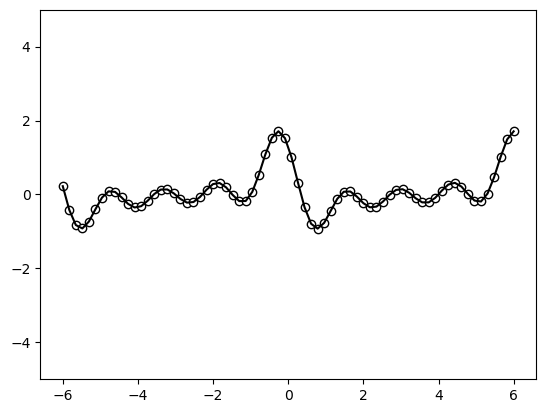

In [3]:
# This part of the code prints the graph we are trying to approximate

degree = 4                        # degree of the target function
scaling = 1                       # scaling of the data
coeffs = [0.15 + 0.15j] * degree  # coefficients of non-zero frequencies
coeff0 = 0.1                      # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])


plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-5, 5)
plt.show()

# Algorithim 1 Distinct Sampling

In this section of the code we define the circuit with a variable n_layers and then get the frequencies folowing algorithim one outlined in the paper

In [4]:
# This is a VQC that changes based on the input n_layers which changes how many frequencies we can sample.

n_layers = 5
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(x, weights):
    for l in range(n_layers):
        qml.RX(x, wires=0, id="x"+str(0))
        qml.Rot(weights[l,0,0], weights[l,0,1], weights[l,0,2], wires=0)
    qml.RZ(x, wires=0, id="x0")
    return qml.expval(qml.PauliZ(wires=0))

x = 1
weights = np.random.random((n_layers, 1, 3))
res = qml.fourier.circuit_spectrum(circuit)(x, weights)

print(qml.draw(circuit)(x, weights))
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

0: ──RX(1.00)──Rot(0.32,0.01,0.78)──RX(1.00)──Rot(0.12,0.30,0.27)──RX(1.00)──Rot(0.40,0.60,0.52)

───RX(1.00)──Rot(0.47,0.83,0.17)──RX(1.00)──Rot(0.69,0.49,0.58)──RZ(1.00)─┤  <Z>
x0: [-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


# Machine Learning Graph with Initial Weights

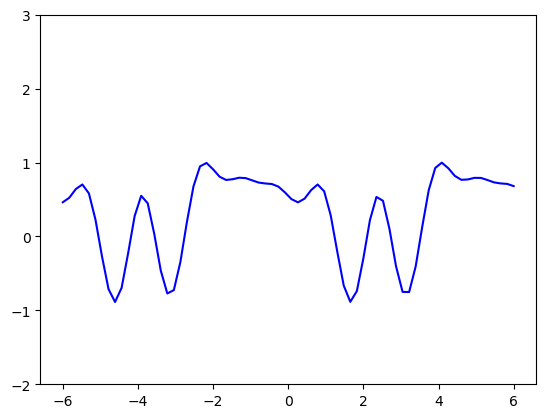

In [5]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = np.random.random((n_layers, 1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70)
random_quantum_model_y = [circuit(x_, weights) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-2,3)
plt.show()

# Machine Learning Gradient Descent

In [6]:
np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

def cost(weights, x, y):
    predictions = [circuit(x_, weights) for x_ in x]
    return square_loss(y, predictions)

max_steps = 40
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.13685184393034172
Cost at step  20: 0.09486493922915018
Cost at step  30: 0.05850482785343765
Cost at step  40: 0.04233127890141485


# Gradient Descent Output with Short Training Time

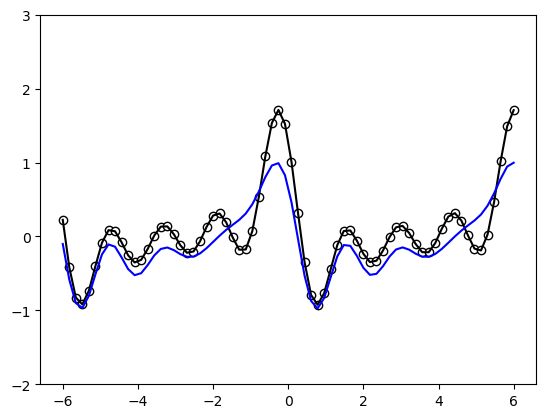

In [7]:
predictions = [circuit(x_, weights) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-2,3)
plt.show()

# Algorithim 2 Tree Sampling

In [8]:
from treelib import Node, Tree

# The tree_sampling function creates a tree and then following the algorithim defined in the paper it creates and returns an array of frequencies that we can sample from.
def tree_sampling(n_layers):
    # Create a 2d array of eigenvalues
    eigvals_array = []

    for i in range(n_layers):
        pauli_x_eigval = qml.eigvals(qml.PauliX(wires=0))/2
        eigvals_array.append(pauli_x_eigval)

    pauli_z_eigval = qml.eigvals(qml.PauliZ(wires=0))/2
    eigvals_array.append(pauli_z_eigval)

    # Create the tree from the eigvals_array
    # The depth of the tree will be n_layers + 1
    def create_tree(eigvals, parent, depth):
        if len(eigvals) == 0:
            return None

        first, *rest = eigvals

        for i in range(len(first)):
            node_name = parent + "_" + str(first[i]) + "_" + str(depth)
            tree.create_node(node_name, node_name, parent=parent, data=first[i])
            create_tree(rest, node_name, depth+1)

    tree = Tree()
    tree.create_node("root", "root", data=0)  # root node
    create_tree(eigvals_array, "root", 1)

    # Function to sum the data values along each unique path starting from the leaves
    def sum_from_leaves(tree, leaf_node):
        path_sum = leaf_node.data
        current_node = leaf_node

        while str(current_node.identifier) != "root":
            parent = tree.parent(current_node.identifier)
            path_sum += parent.data
            current_node = parent

        return path_sum

    upperCaseLambdaArray = []
    # Calculate and print the sum of data values for each unique path starting from the leaves
    for leaf in tree.leaves():
        sum = sum_from_leaves(tree, leaf)
        upperCaseLambdaArray.append(sum)

    frequencyArray = []
    # Create frequency array
    for i in range(len(upperCaseLambdaArray)):
        for j in range(len(upperCaseLambdaArray)):
            frequency = upperCaseLambdaArray[i] - upperCaseLambdaArray[j]
            frequencyArray.append(frequency)

    return frequencyArray

frequencyArray = tree_sampling(n_layers)

# Algorithm 3 Grid Sampling

In [9]:
# Helper function to create a range of floats for Algorithm 3
def range_with_floats(start, stop, step):
    while stop >= start:
        yield start
        start += step

# Algorithim 3
# Number of layers

# For the circuit we use with each algorithm the number of encoding gates is number of layers + 1
# This is because we have one additional encoding gate RZ.
numberOfEncodingGates = n_layers + 1

# Because the eigenvalues of PauliX and PauliZ gates are -0.5 and 0.5 we know that w_max is numberOfEncodingGates
wMax = numberOfEncodingGates

# We need to assign a step value a resonable step value is anywhere from 0 to 1
step = 1

grid = []

# Create the grid
for i in range_with_floats(0, wMax, step):
    grid.append(i)

print(grid)

[0, 1, 2, 3, 4, 5, 6]


# Constructing the Approximation Function

Classically training the approximation function to prepare for the algorithms. There is no gradient descent, as we can compute the optimization algorithm by explicitly computing $w$.

In [10]:
def construct_phi(x, frequencies):
  # constructs phi or tilde_phi 
  # based on x and the given frequencies

  phi = np.zeros(2* len(frequencies))
  for i in range(len(frequencies)):
    phi[2*i] = np.cos(frequencies[i] * x)
    phi[2*i+1] = np.sin(frequencies[i] * x)
  
  return phi

def construct_Phi(xi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = np.zeros((M, P))

  for i in range(M):
    phi = construct_phi(xi_array[i], frequencies)
    for j in range(P):
      Phi[i][j] = phi[j]
  return Phi

def construct_w(xi_array, yi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = construct_Phi(xi_array, frequencies)
  lambda_hyper = 0.001

  Phi_T = np.transpose(Phi)

  w_1 = np.matmul(Phi_T, Phi) + M*lambda_hyper * np.identity(P)
  w_2 = np.matmul(np.linalg.inv(w_1), Phi_T)
  w = np.matmul(w_2, yi_array)
  return w

def f(x, w, frequencies):
  phi = construct_phi(x, frequencies)
  return np.matmul(w, phi)

# Output of Approximated Target Function

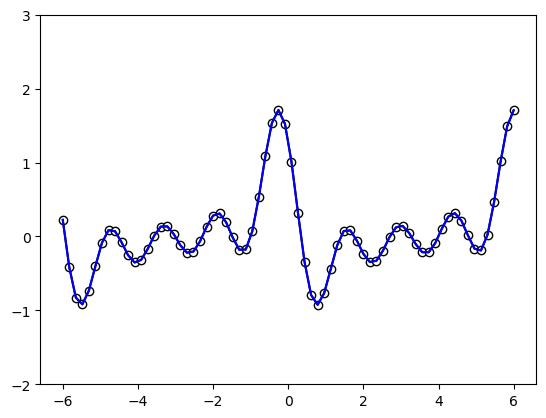

In [11]:
x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])

frequencies = res['x0']
xi_array = x
yi_array = target_y
w = construct_w(xi_array, yi_array, frequencies)

target_y_f = np.array([f(x_, w, frequencies) for x_ in x])

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-2, 3)

plt.plot(x, target_y_f, c='blue')
plt.show()